In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date, concat, lit, date_sub, add_months
from pyspark.sql.types import LongType, StringType, IntegerType, StructType, StructField, DecimalType, TimestampType

# Initialize Spark session
spark = SparkSession.builder \
    .appName("app_bronze_to_silver_cards_data") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "2") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.262,"
            "org.postgresql:postgresql:42.5.4") \
    .getOrCreate()

# Define schema for transactions
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("client_id", IntegerType(), False),
    StructField("card_brand", StringType(), True),
    StructField("card_type", StringType(), True),
    StructField("card_number", StringType(), False),
    StructField("expires", StringType(), False),
    StructField("cvv", IntegerType(), False),
    StructField("has_chip", StringType(), True),
    StructField("num_cards_issued", IntegerType(), True),
    StructField("credit_limit", StringType(), True),
    StructField("acct_open_date", StringType(), True),
    StructField("year_pin_last_changed", IntegerType(), True),
    StructField("card_on_dark_web", StringType(), True)
])

# Read CSV from MinIO bucket
df_src = spark.read \
    .option("header", "true") \
    .schema(schema) \
    .csv("s3a://bronze/cards/cards_data.csv")

# Transform data with proper types
df_transformed = df_src \
    .withColumn("credit_limit", 
                regexp_replace(col("credit_limit"), "\\$", "").cast("decimal(10,2)")) \
    .withColumn("acct_open_date", 
                to_date(col("acct_open_date"), "MM/yyyy")) \
    .withColumn(
            "expires",
            date_sub(
                add_months(
                    to_date(concat(lit("01/"), col("expires")), "dd/MM/yyyy"),
                    1
                    ),
                    1
                )
            )

print("\nTransformed Schema:")
df_transformed.printSchema()
df_transformed.show(5, truncate=False)

# Write to minio bucket
df_transformed.write.mode("overwrite").parquet("s3a://silver/cards/")

print("Data successfully loaded to Minio Bucket")


Transformed Schema:
root
 |-- id: integer (nullable = true)
 |-- client_id: integer (nullable = true)
 |-- card_brand: string (nullable = true)
 |-- card_type: string (nullable = true)
 |-- card_number: string (nullable = true)
 |-- expires: date (nullable = true)
 |-- cvv: integer (nullable = true)
 |-- has_chip: string (nullable = true)
 |-- num_cards_issued: integer (nullable = true)
 |-- credit_limit: decimal(10,2) (nullable = true)
 |-- acct_open_date: date (nullable = true)
 |-- year_pin_last_changed: integer (nullable = true)
 |-- card_on_dark_web: string (nullable = true)

+----+---------+----------+---------------+----------------+----------+---+--------+----------------+------------+--------------+---------------------+----------------+
|id  |client_id|card_brand|card_type      |card_number     |expires   |cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|card_on_dark_web|
+----+---------+----------+---------------+----------------+----------+--

In [2]:
print("Stopping spark session")
spark.stop()
print("spark session stopped successfully")

Stopping spark session
spark session stopped successfully


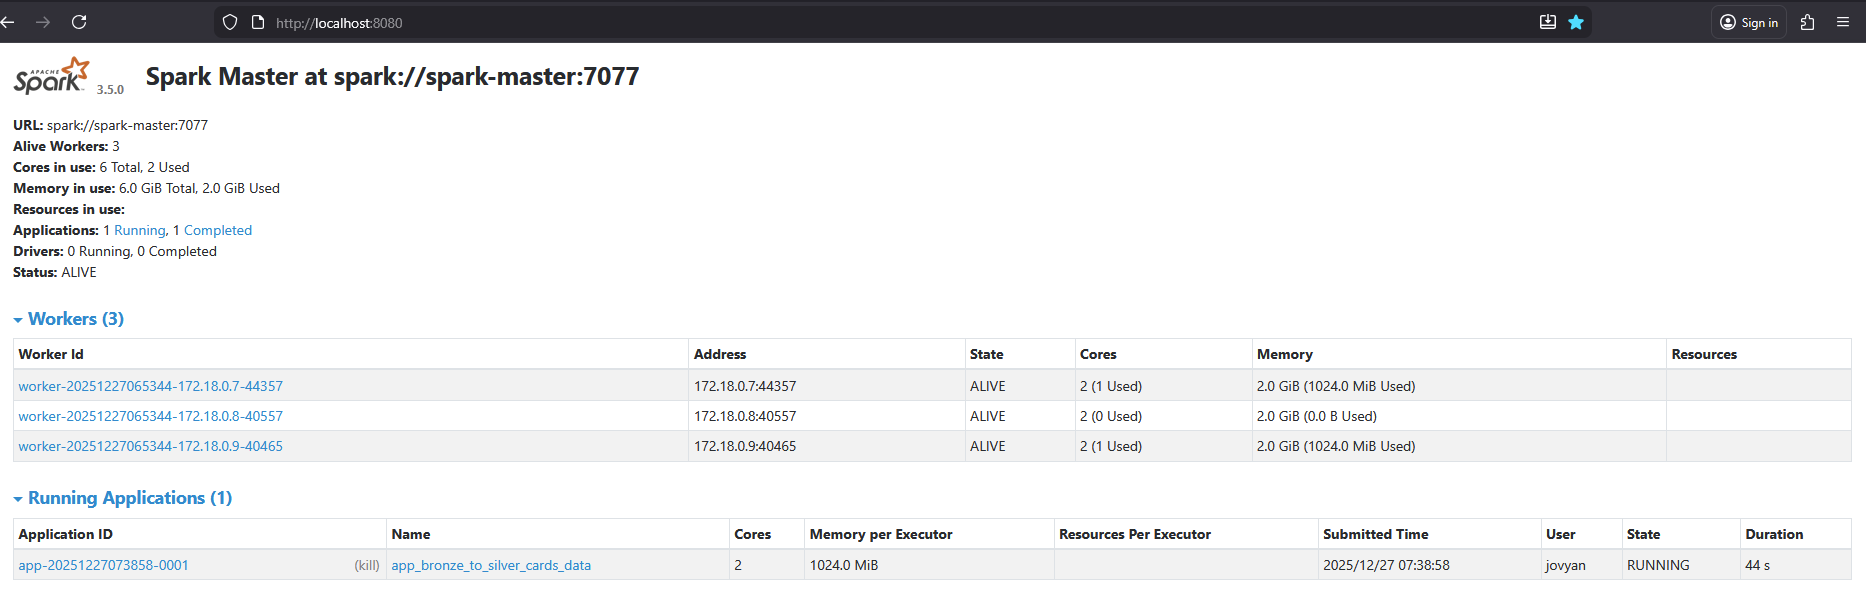

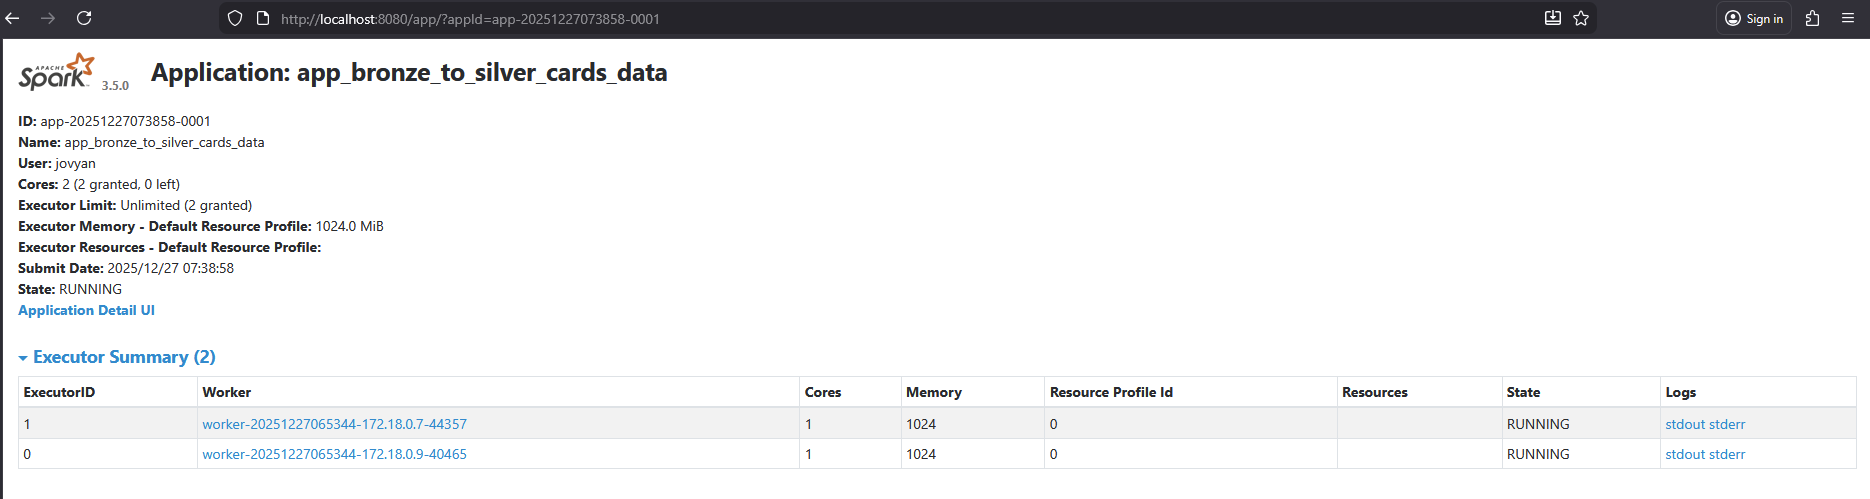